# <span style="color:red"> Main Modelling - Logistic Regression - Gridsearch </span>

* read in pickle v02
* generate logistic regression models
* try different feature sets and save model each time
* all features available ie normalised counts and pos counts with some drops plus unique words, adj, adv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
import re
import pickle
import os

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import label_binarize

import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# import class to run modelling steps
from translator_modelling import Modelling

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


Bad key "text.kerning_factor" on line 4 in
/Users/Steven/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Load the dataframe containing text chunks and related variables

In [2]:
in_full_path = '../../../../Documents/murakami/pkl3/df_all_v02.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

### Check the dataframe is as expected

In [3]:
df.head(1)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,...,then_adv,more_adv,even_adv,why_adv,maybe_adv,again_adv,now_adv,just_adv,how_adv,where_adv,very_adv,only_adv,there_adv,still_adv,so_adv,too_adv,when_adv,all_adv,here_adv,never_adv,as_adv,new_adj,other_adj,more_adj,small_adj,deep_adj,whole_adj,first_adj,bad_adj,little_adj,next_adj,much_adj,own_adj,hard_adj,last_adj,only_adj,big_adj,right_adj,long_adj,old_adj,strange_adj,same_adj,young_adj,sure_adj,able_adj,real_adj,different_adj,good_adj,few_adj,vlong_words_count
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.59322,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(5212, 142)

In [5]:
df.columns

Index(['book_chunk_no', 'number', 'title', 'text', 'fstop_indices',
       'split_indices', 'chunks', 'translator', 'book_title', 'parsed',
       ...
       'strange_adj', 'same_adj', 'young_adj', 'sure_adj', 'able_adj',
       'real_adj', 'different_adj', 'good_adj', 'few_adj',
       'vlong_words_count'],
      dtype='object', length=142)

### Check the baseline

In [6]:
baseline_acc = df['trans_code'].value_counts(normalize=True).max()
baseline_acc

0.39927091327705294

## 1. Features = Basic Counts
* choose predictor features
* set predictor and target variables X, y
* perform train/test split
* normalise predictor variables
* gridsearch logistic regression
* score the fitted model
* save fitted model

In [7]:
# prepare modelling
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lr1 = Modelling(df, model)

# select feature groups for modelling
predictor_cols = lr1.feature_select()

# drop some individual features eg. those potentially related to page formatting
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = lr1.drop_features(predictor_cols, cols_to_drop)

# prep data i.e. set X and y, train/test split, normalise predictor variables
X_train, X_test, y_train, y_test, idx_train, idx_test = lr1.modelling_prep(predictor_cols, 'trans_code')

# gridsearch model parameters, score fitted model
params = {'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}
# lreg_gs_01 = lr.gridsearch(model, params, X_train, y_train)
lr1.gridsearch(params, X_train, y_train)

# score the fitted model
lreg_gs_01_results = lr1.gridsearch_score(X_train, y_train, X_test, y_test)

# save fitted model
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_01'
out_full_path = out_path + out_name + '.pkl'
lr1.save_model(out_full_path)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  47 out of  50 | elapsed:    5.4s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    5.6s finished


Best Parameters:
{'C': 100, 'penalty': 'l2'}
Best estimator mean cross validated training score:
0.5236221107147895
Best estimator score on the full training set:
0.5257855600863517
Best estimator score on the test set:
0.5426653883029722
ROC-AUC score on the test set:
Class 0: 0.74
Class 1: 0.77
Class 2: 0.61


## 2. Features = Basic Counts + POS Counts

In [8]:
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lr2 = Modelling(df, model)

predictor_cols = lr2.feature_select(basic_counts=True, pos_counts=True)
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = lr2.drop_features(predictor_cols, cols_to_drop)

X_train, X_test, y_train, y_test, idx_train, idx_test = lr2.modelling_prep(predictor_cols, 'trans_code')

params = {'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}
lr2.gridsearch(params, X_train, y_train)

lreg_gs_02_results = lr2.gridsearch_score(X_train, y_train, X_test, y_test)

out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_02'
out_full_path = out_path + out_name + '.pkl'
lr2.save_model(out_full_path)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    6.3s finished


Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.5907856667846995
Best estimator score on the full training set:
0.5967857999520269
Best estimator score on the test set:
0.6049856184084372
ROC-AUC score on the test set:
Class 0: 0.79
Class 1: 0.81
Class 2: 0.74


## 3. Features = Basic Counts + POS Counts + words

In [9]:
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lr3 = Modelling(df, model)

predictor_cols = lr3.feature_select(basic_counts=True, pos_counts=True, words=True)
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = lr3.drop_features(predictor_cols, cols_to_drop)

X_train, X_test, y_train, y_test, idx_train, idx_test = lr3.modelling_prep(predictor_cols, 'trans_code')

params = {'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}
lr3.gridsearch(params, X_train, y_train)

lreg_gs_03_results = lr3.gridsearch_score(X_train, y_train, X_test, y_test)

out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_03'
out_full_path = out_path + out_name + '.pkl'
lr3.save_model(out_full_path)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  47 out of  50 | elapsed:    8.9s remaining:    0.6s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    9.4s finished


Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.652193539286218
Best estimator score on the full training set:
0.6596306068601583
Best estimator score on the test set:
0.6653883029721956
ROC-AUC score on the test set:
Class 0: 0.82
Class 1: 0.84
Class 2: 0.85


## 4. Features = Basic Counts + POS Counts + words + adj

In [10]:
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lr4 = Modelling(df, model)

predictor_cols = lr4.feature_select(basic_counts=True, pos_counts=True, words=True, adj=True)
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = lr4.drop_features(predictor_cols, cols_to_drop)

X_train, X_test, y_train, y_test, idx_train, idx_test = lr4.modelling_prep(predictor_cols, 'trans_code')

params = {'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}
lr4.gridsearch(params, X_train, y_train)

lreg_gs_04_results = lr4.gridsearch_score(X_train, y_train, X_test, y_test)

out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_04'
out_full_path = out_path + out_name + '.pkl'
lr4.save_model(out_full_path)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   14.7s finished


Best Parameters:
{'C': 1, 'penalty': 'l2'}
Best estimator mean cross validated training score:
0.6689844283036955
Best estimator score on the full training set:
0.681458383305349
Best estimator score on the test set:
0.6768935762224353
ROC-AUC score on the test set:
Class 0: 0.84
Class 1: 0.84
Class 2: 0.85


## 5. Features = Basic Counts + POS Counts + words + adj + adv

In [11]:
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lr5 = Modelling(df, model)

predictor_cols = lr5.feature_select(basic_counts=True, pos_counts=True, words=True, adj=True, adv=True)
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = lr5.drop_features(predictor_cols, cols_to_drop)

X_train, X_test, y_train, y_test, idx_train, idx_test = lr5.modelling_prep(predictor_cols, 'trans_code')

params = {'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}
lr5.gridsearch(params, X_train, y_train)

lreg_gs_05_results = lr5.gridsearch_score(X_train, y_train, X_test, y_test)

out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_05'
out_full_path = out_path + out_name + '.pkl'
lr5.save_model(out_full_path)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   34.7s finished


Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.6766617438342244
Best estimator score on the full training set:
0.7004077716478772
Best estimator score on the test set:
0.6951102588686481
ROC-AUC score on the test set:
Class 0: 0.86
Class 1: 0.86
Class 2: 0.86


## 6. Features = Basic Counts + POS Counts + words + adj + adv + vader

In [12]:
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lr6 = Modelling(df, model)

predictor_cols = lr6.feature_select(basic_counts=True, pos_counts=True, vader=True, words=True, 
                                   adj=True, adv=True)
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = lr6.drop_features(predictor_cols, cols_to_drop)

X_train, X_test, y_train, y_test, idx_train, idx_test = lr6.modelling_prep(predictor_cols, 'trans_code')

params = {'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}
lr6.gridsearch(params, X_train, y_train)

lreg_gs_06_results = lr6.gridsearch_score(X_train, y_train, X_test, y_test)

out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_06'
out_full_path = out_path + out_name + '.pkl'
lr6.save_model(out_full_path)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  1.9min finished


Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.6826578113259693
Best estimator score on the full training set:
0.708323338930199
Best estimator score on the test set:
0.6883988494726749
ROC-AUC score on the test set:
Class 0: 0.86
Class 1: 0.86
Class 2: 0.86


## Confusion Matrices

In [13]:
lreg_results = [lreg_gs_01_results,
                lreg_gs_02_results,
                lreg_gs_03_results,
                lreg_gs_04_results,
                lreg_gs_05_results,
                lreg_gs_06_results]

In [14]:
for i, results in enumerate(lreg_results):
    print('model:', i+1)
    print(pd.DataFrame(results['conmat'], index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                             columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel']))
    print('\n')

model: 1
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 221              108                 16
actual rubin                     86              322                  8
actual gabriel                  126              133                 23


model: 2
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 222               82                 41
actual rubin                     77              310                 29
actual gabriel                   83              100                 99


model: 3
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 229               81                 35
actual rubin                     72              304                 40
actual gabriel                   61               60                161


model: 4
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum       

## Confusion Matrix Comments
* Model 1 - basic counts: does very well for Birnbaum and Rubin but very badly for Gabriel
* Model 2 - basic + POS counts: slight improvement for Birnbaum, a slight drop for Rubin. Gabriel is much improved but still the lowest accuracy
* Model 3 - basic + POS + word counts: Gabriel accuracy imrpoves significantly
* Model 4 - basic + POS + word counts + adj: no significant improvement on the test scores
* Model 5 - basic + POS + word counts + adj + adv: slight improvement across the board
* Model 6 - basic + POS + word counts + adj + adv + vader: no significant improvement on the test scores

## Classification Report
!!! to be set up!!!

In [15]:
# print(classification_report(y_test, lr5.model_gs.predict(X_test)))

In [16]:
model_nums = []
cv_scores = []
train_scores = []
test_scores = []
auc_0 = []
auc_1 = []
auc_2 = []


for i, results in enumerate(lreg_results):
    model_nums.append(i+1)
    cv_scores.append(results['Best_CV_Score'])
    train_scores.append(results['Best_Train_Score'])
    test_scores.append(results['Best_Test_Score'])
    auc_0.append(results['AUC_Class_0'])
    auc_1.append(results['AUC_Class_1'])
    auc_2.append(results['AUC_Class_2'])

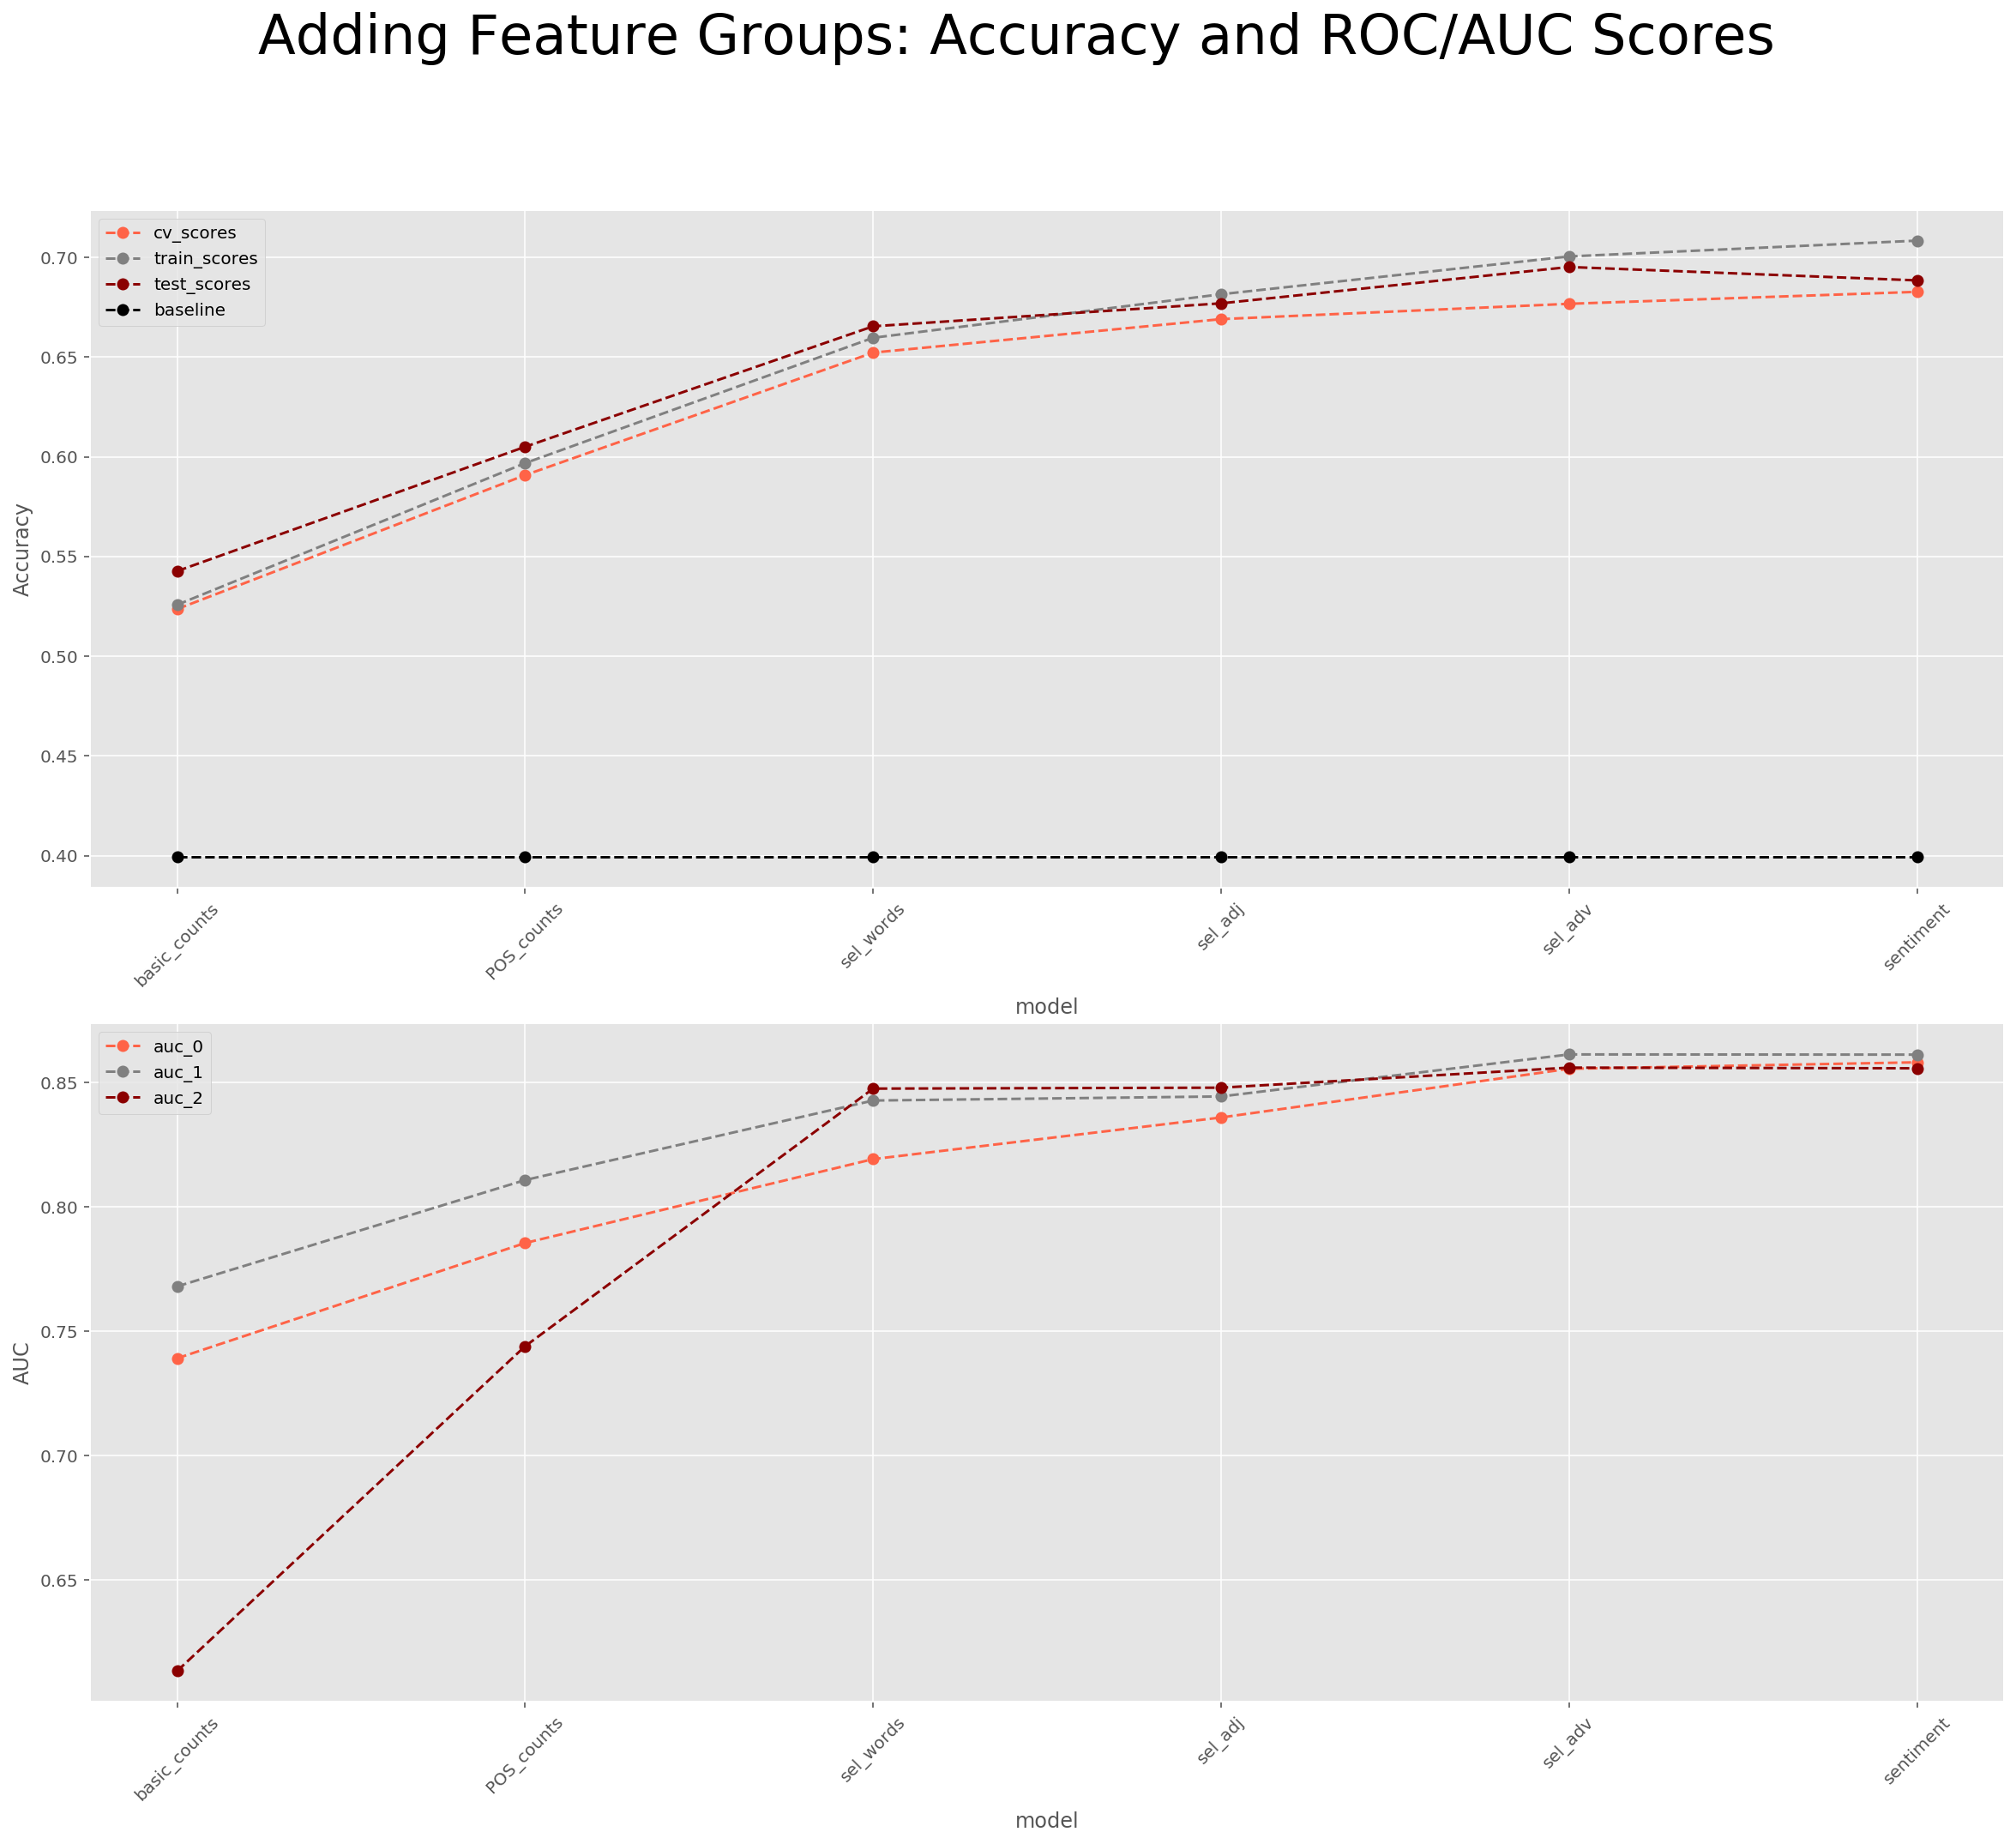

In [30]:
sns.set_palette(['tomato', 'gray', 'darkred', 'black'])
dict_cv_scores = {'model': model_nums, 
                  'cv_scores': cv_scores, 
                  'train_scores': train_scores,
                  'test_scores': test_scores,
                  'auc_0': auc_0,
                  'auc_1': auc_1,
                  'auc_2': auc_2,}
df_cv_scores = pd.DataFrame(dict_cv_scores)
df_cv_scores['baseline'] = baseline_acc

fig, ax = plt.subplots(nrows=2, figsize=(20,16))
fig.suptitle('Adding Feature Groups: Accuracy and ROC/AUC Scores', fontsize=32)

df_cv_scores.sort_values(by='model').plot(x='model', y='cv_scores', linestyle='--', marker='o', ax=ax[0])
df_cv_scores.sort_values(by='model').plot(x='model', y='train_scores', linestyle='--', marker='o', ax=ax[0])
df_cv_scores.sort_values(by='model').plot(x='model', y='test_scores', linestyle='--', marker='o', ax=ax[0])
df_cv_scores.sort_values(by='model').plot(x='model', y='baseline', linestyle='--', marker='o', ax=ax[0])

df_cv_scores.sort_values(by='model').plot(x='model', y='auc_0', linestyle='--', marker='o', ax=ax[1])
df_cv_scores.sort_values(by='model').plot(x='model', y='auc_1', linestyle='--', marker='o', ax=ax[1])
df_cv_scores.sort_values(by='model').plot(x='model', y='auc_2', linestyle='--', marker='o', ax=ax[1])

labels = ['', 'basic_counts', 'POS_counts', 'sel_words', 'sel_adj', 'sel_adv', 'sentiment']
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels[1] = 'Testing'

ax[0].set_xticklabels(labels)
ax[0].tick_params(axis='x', labelrotation=45)
ax[1].set_xticklabels(labels)
ax[1].tick_params(axis='x', labelrotation=45)
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('AUC')


plt.savefig('../../../../Documents/murakami/plots/lreg_sel_feature_scores.png')
plt.show()

## Run a best logistic regression

In [18]:
lr5.model_gs.best_params_

{'C': 1, 'penalty': 'l1'}

In [19]:
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lrf = Modelling(df, model)

predictor_cols = lrf.feature_select(basic_counts=True, pos_counts=True, vader=False, words=True, 
                                   adj=True, adv=True)
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = lrf.drop_features(predictor_cols, cols_to_drop)

X_train, X_test, y_train, y_test, idx_train, idx_test = lrf.modelling_prep(predictor_cols, 'trans_code')

params = {'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}
lrf.gridsearch(params, X_train, y_train)

lreg_gs_fin_results = lrf.gridsearch_score(X_train, y_train, X_test, y_test)

out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_final'
out_full_path = out_path + out_name + '.pkl'
lrf.save_model(out_full_path)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   34.1s finished


Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.6766617438342244
Best estimator score on the full training set:
0.7004077716478772
Best estimator score on the test set:
0.6951102588686481
ROC-AUC score on the test set:
Class 0: 0.86
Class 1: 0.86
Class 2: 0.86


## Classification Report

In [20]:
print(classification_report(y_test, lrf.model_gs.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       345
           1       0.72      0.73      0.73       416
           2       0.67      0.64      0.65       282

    accuracy                           0.70      1043
   macro avg       0.69      0.69      0.69      1043
weighted avg       0.69      0.70      0.69      1043



## Precision-Recall Plot

In [21]:
probabilities = lrf.model_gs.predict_proba(X_test)

In [22]:
def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

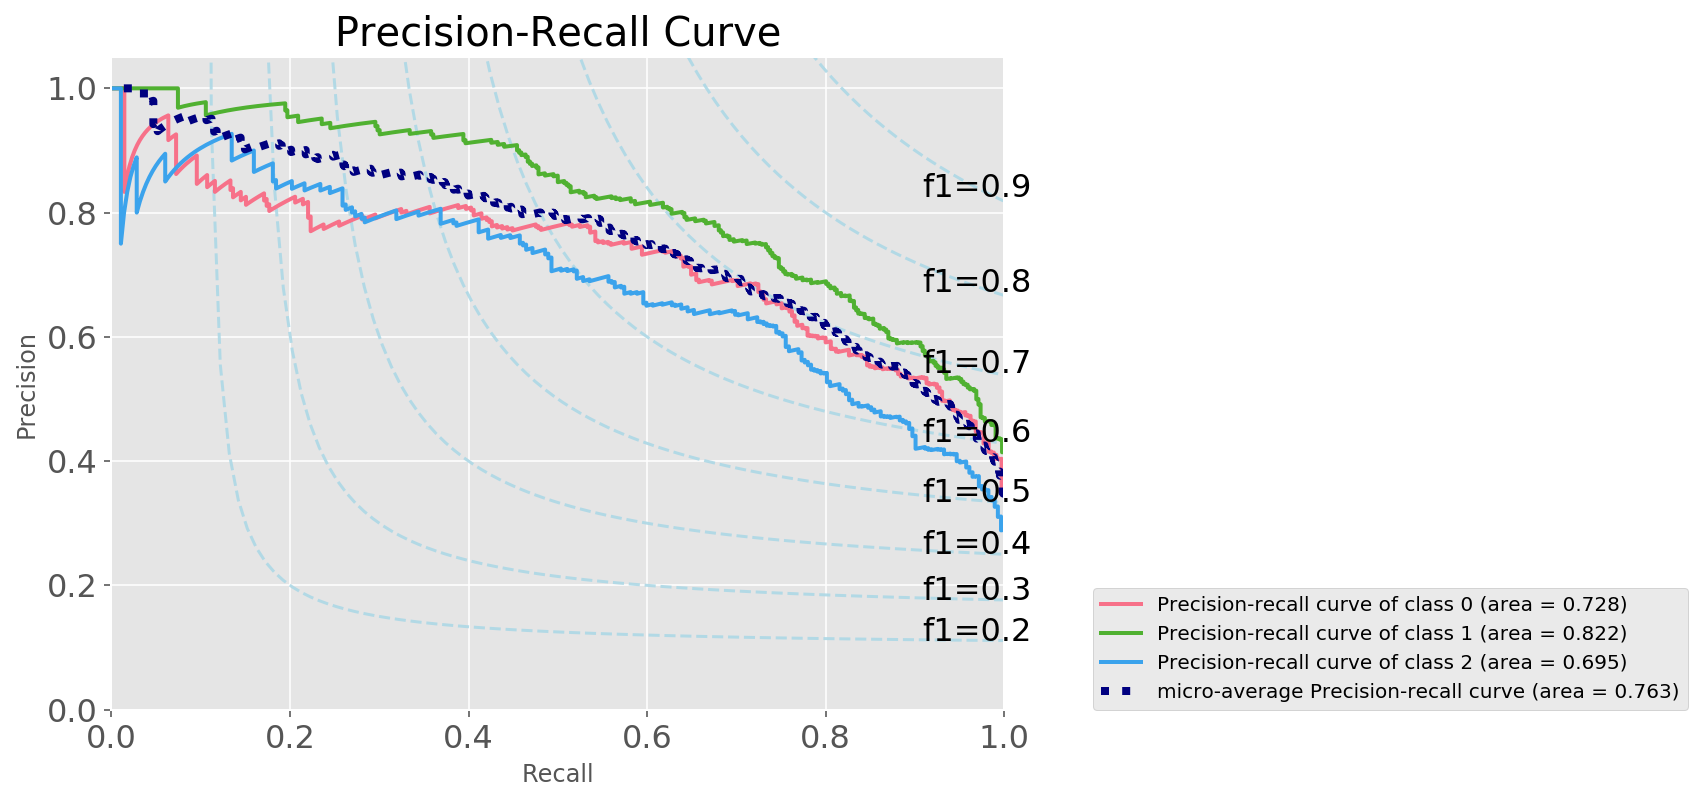

In [23]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

In [24]:
# label binarizer 
y_bin = label_binarize(y_test, lrf.model_gs.classes_)

In [25]:
print('Area under precision-recall curve:')
for i, class_ in enumerate(lrf.model_gs.classes_):
    print('Class {}:'.format(class_), round(average_precision_score(y_bin[:,i],lrf.model_gs.predict_proba(X_test)[:,i]),4))

Area under precision-recall curve:
Class 0: 0.7283
Class 1: 0.8216
Class 2: 0.6949


## ROC Plot

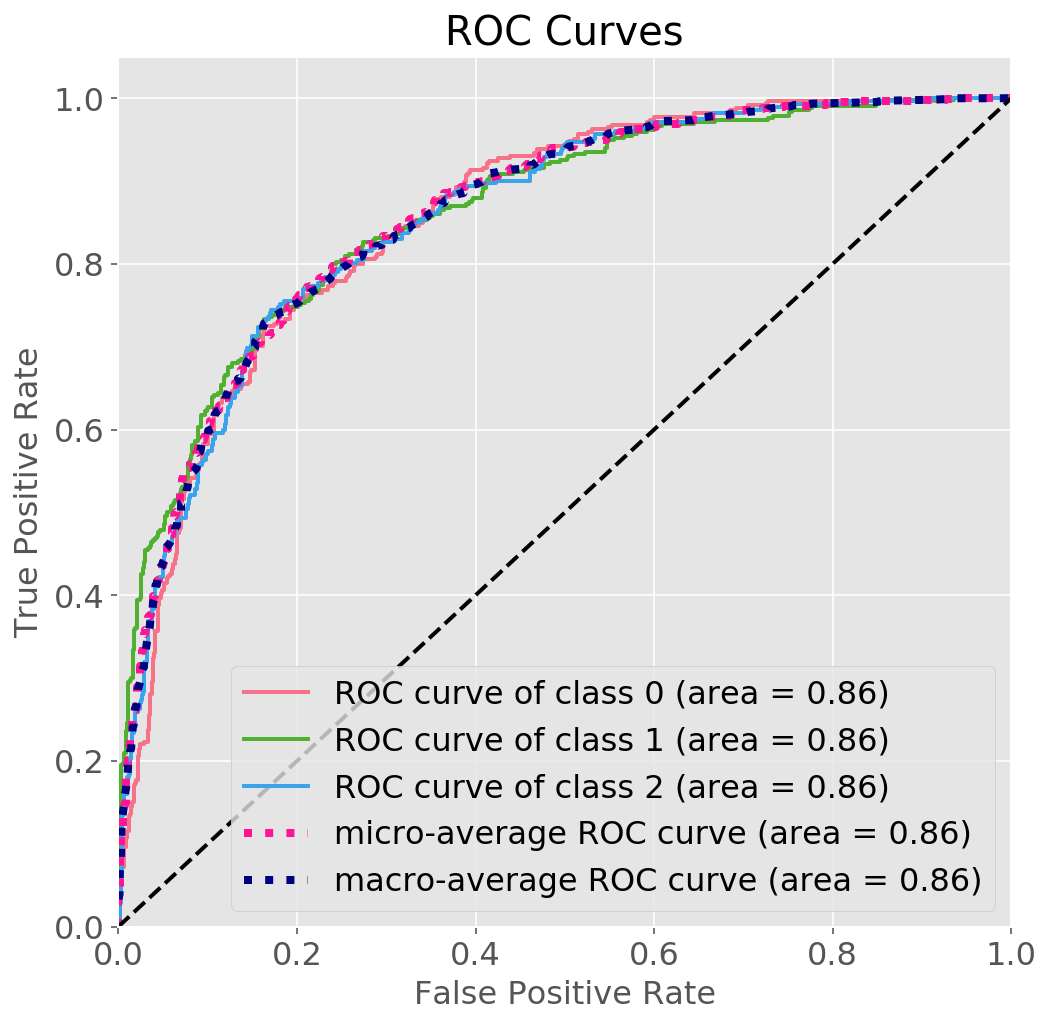

In [26]:
skplt.metrics.plot_roc(y_test, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,8), cmap=cmap)
plt.show()